# **PyCaret**


PyCaret es una biblioteca de código abierto de aprendizaje automático (machine learning) para Python que facilita y agiliza el proceso de desarrollo y experimentación con modelos de aprendizaje automático. Fue desarrollado para simplificar tareas comunes en el flujo de trabajo de aprendizaje automático, como la preparación de datos, la selección de características, la creación de modelos, la evaluación y comparación de modelos, y la interpretación de resultados.

Las características principales de PyCaret son:

Interfaz sencilla: PyCaret proporciona una interfaz de línea de comandos simple e intuitiva, lo que lo hace accesible incluso para usuarios nuevos en aprendizaje automático.

Automatización del flujo de trabajo: PyCaret automatiza muchas de las tareas repetitivas y tediosas que generalmente se realizan en el proceso de desarrollo de modelos, lo que permite a los usuarios centrarse más en la experimentación y la iteración rápida.

Soporte para múltiples bibliotecas de aprendizaje automático: PyCaret es compatible con varias bibliotecas populares de aprendizaje automático, como scikit-learn, XGBoost, LightGBM, CatBoost, etc. Esto permite a los usuarios comparar fácilmente diferentes algoritmos sin necesidad de escribir mucho código.

Funciones de preprocesamiento de datos: PyCaret ofrece funcionalidades para la preparación y limpieza de datos, incluyendo manejo de valores faltantes, codificación de variables categóricas, y más.

Comparación de modelos: PyCaret permite comparar rápidamente el rendimiento de varios modelos utilizando diferentes métricas, lo que ayuda a seleccionar el mejor modelo para un problema en particular.

Sintonización automática de hiperparámetros: PyCaret puede realizar automáticamente la búsqueda de hiperparámetros para optimizar los modelos, lo que reduce la necesidad de ajustar manualmente los hiperparámetros.

Interpretación de modelos: PyCaret ofrece funciones para interpretar y visualizar los modelos entrenados, lo que facilita la comprensión de cómo funcionan y qué características son más importantes para la predicción.

En general, PyCaret es una excelente herramienta para acelerar y simplificar el proceso de desarrollo de modelos de aprendizaje automático, lo que lo hace especialmente útil para usuarios que deseen experimentar con diferentes algoritmos y técnicas de manera eficiente. Sin embargo, es importante tener en cuenta que, como en cualquier biblioteca de alto nivel, la flexibilidad y control sobre el flujo de trabajo pueden ser más limitados que al utilizar bibliotecas de nivel más bajo como scikit-learn.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Dividir la data en entraniemo y prueba

import pycaret
from pycaret.classification import *

from skopt import BayesSearchCV
import xgboost as xgb


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

import xgboost as xgb

import warnings

warnings.filterwarnings("ignore")

def MetricasMatrixConfusion(y,modelo,X,tipo="ml"):
    
    if (tipo=="ml"):
        Predicciones=modelo.predict(X)
    else:
        Probabilidad=modelo.predict(exog=X)
        Predicciones=np.where(Probabilidad <0.5,0,1)
    
    Accuracy_RF_test=metrics.accuracy_score(y,Predicciones)
    print(f'Accuracy: {Accuracy_RF_test}')
    Reporte_RF_test=metrics.classification_report(y,Predicciones)
    print(Reporte_RF_test)

    td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
    td2=pd.concat([y.reset_index(drop=True),td1],axis=1)
    td2.columns=["Realidad","Predicion"]
    Matrix=pd.crosstab(td2["Realidad"],td2["Predicion"],margins=True)
    Matrix_Normalizada=pd.crosstab(td2["Realidad"],td2["Predicion"],normalize=0)
    
    sns.heatmap(Matrix_Normalizada, annot=True,linewidths = 0.01, cmap = "Blues")
    
    plt.show()
    print(Matrix)
    
def curva_roc(y,modelo,X,tipo="ml"):
    if (tipo=="ml"):
        y_pprob = modelo.predict_proba(X)[::,1] ## Sklearn
        Probabilidad=modelo.predict_proba(X=X)[:,1]
    else:
        y_pprob=modelo.predict(exog=X)
        Probabilidad=modelo.predict(exog=X)
    
    false_positive, true_positive, _ = roc_curve(y,  y_pprob)
    print('Modelo AUC:',roc_auc_score(y,  y_pprob))
    
    fpr, tpr, thresholds = roc_curve(y, Probabilidad )
    AUC_AD=round(roc_auc_score(y, Probabilidad),4)
   
    random_probs = [0 for i in range(len(y))]
    p_fpr, p_tpr, _ = roc_curve(y, random_probs, pos_label=1)
    plt.plot(fpr,tpr,linestyle="--",color="green",label="Decision Tree, AUC="+str(AUC_AD))
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title("CURVA ROC")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.legend()
    plt.show()

In [2]:
df=pd.read_csv("BaseModelos.csv",index_col=False)
df.rename(columns={"CompraSeguro":"target"},inplace=True)

In [3]:
Cat_chi2=pd.read_csv("CategoricasChi2.csv")
Cat_chi2.shape

Cat_Mutual=pd.read_csv("CategoricasMutualInfo.csv")
Cat_Mutual.shape

(17, 1)

In [4]:
Num_corr=pd.read_csv("Num_Sig_Correlacion_Parametrica.csv")
Num_corr.shape

Num_Mutual=pd.read_csv("Num_MutualInfo.csv")
Num_Mutual.shape

(10, 2)

In [5]:
Variables=Cat_Mutual.Variables.tolist()+Num_Mutual.Variables.tolist()

In [6]:
Historia=df[df["Tipo Archivo"]=="Entrenamiento"].reset_index(drop=True)

In [7]:
X= Historia[Variables]

In [8]:
y=Historia[["target"]].astype(int).astype("category")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123,stratify=y)

# **Configuración**

In [10]:
pycaret_train=pd.concat([x_train,y_train],axis=1)
pycaret_test=pd.concat([x_test,y_test],axis=1)

In [11]:
Model = setup(data=pycaret_train, test_data=pycaret_test, target='target', session_id=123,fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(2999, 28)"
4,Transformed data shape,"(4862, 27)"
5,Transformed train set shape,"(3962, 27)"
6,Transformed test set shape,"(900, 27)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [12]:
models_to_compare = ['rf', 'xgboost', 'lightgbm', 'catboost', 'gbc', 'lr']
best_model = compare_models(include=models_to_compare, fold=5, sort='AUC')
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9500,0.9100,0.4580,0.5687,0.5070,0.4810,0.4843,0.4060
lr,Logistic Regression,0.8437,0.9091,0.8054,0.2374,0.3661,0.3060,0.3817,0.1040
gbc,Gradient Boosting Classifier,0.9404,0.9079,0.5174,0.4782,0.4945,0.4631,0.4648,0.1940
catboost,CatBoost Classifier,0.9528,0.9075,0.4572,0.6086,0.5198,0.4957,0.5024,1.6360
xgboost,Extreme Gradient Boosting,0.9462,0.8883,0.4580,0.5321,0.4890,0.4609,0.4640,0.5300
rf,Random Forest Classifier,0.9433,0.8858,0.3062,0.4961,0.3728,0.3454,0.3591,1.2180


Processing:   0%|          | 0/29 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

* CatBoost es una biblioteca de aprendizaje automático desarrollada por Yandex que se utiliza para resolver problemas de clasificación, regresión y ranking. Se basa en el algoritmo de Gradient Boosting, pero se destaca por su capacidad de trabajar con datos categóricos sin necesidad de preprocesarlos mediante técnicas de codificación.

In [13]:
best_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9476,0.9141,0.3636,0.5000,0.4211,0.3943,0.3998
1,0.9524,0.9280,0.5000,0.6000,0.5455,0.5205,0.5230
2,0.9619,0.9301,0.6667,0.6667,0.6667,0.6465,0.6465
3,0.9619,0.9524,0.5000,0.7500,0.6000,0.5808,0.5940
4,0.9571,0.8144,0.3333,0.8000,0.4706,0.4522,0.4998
5,0.9524,0.9301,0.5833,0.5833,0.5833,0.5581,0.5581
6,0.9429,0.8548,0.2500,0.5000,0.3333,0.3069,0.3272
7,0.9667,0.9596,0.6667,0.7273,0.6957,0.6781,0.6788
8,0.9429,0.8443,0.3333,0.5000,0.4000,0.3713,0.3797


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

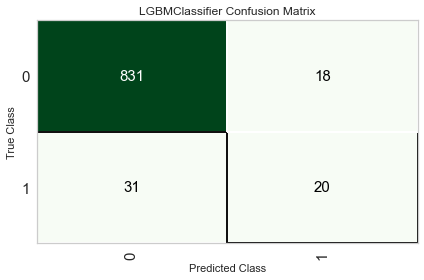

Finished loading model, total used 100 iterations


In [14]:
plot_model(best_model, plot='confusion_matrix')

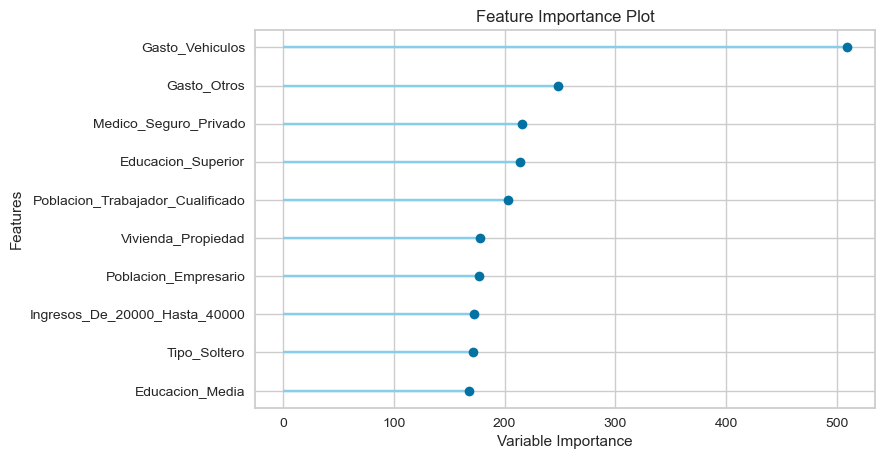

Finished loading model, total used 100 iterations


In [15]:
plot_model(best_model, plot='feature')

Finished loading model, total used 100 iterations


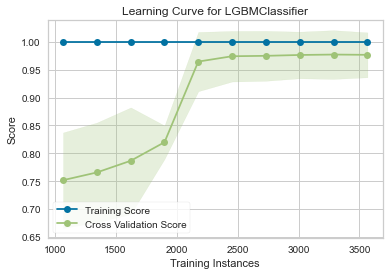

In [16]:
plot_model(best_model, plot='learning')

In [17]:
tuned_best_model = tune_model(best_model,search_library='scikit-optimize',return_train_score=True,
                       fold=3,choose_better=True,optimize='AUC',n_iter=100)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Finished loading model, total used 125 iterations


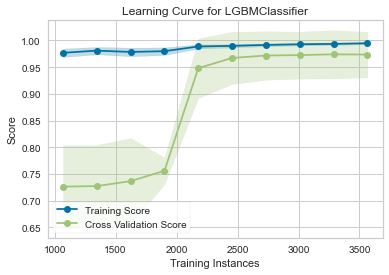

In [18]:
plot_model(tuned_best_model, plot='learning')

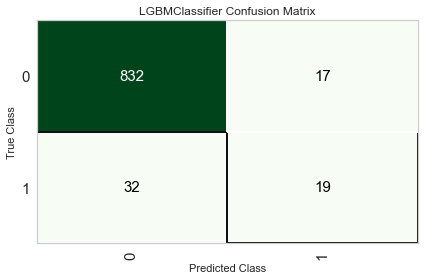

Finished loading model, total used 125 iterations


In [19]:
plot_model(tuned_best_model, plot='confusion_matrix')

In [20]:
y_train=y_train.astype(int)

In [21]:
Modelo= tuned_best_model
Modelo.fit(x_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7433856906830993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433856906830993
[LightGBM] [Warning] bagging_fraction is set=0.9785130099616469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785130099616469


LGBMClassifier(bagging_fraction=0.9785130099616469, bagging_freq=2,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.7433856906830993, importance_type='split',
               learning_rate=0.06457894957229718, max_depth=-1,
               min_child_samples=48, min_child_weight=0.001,
               min_split_gain=0.6656989787918607, n_estimators=181, n_jobs=-1,
               num_leaves=199, objective=None, random_state=123,
               reg_alpha=2.468768356558021e-06, reg_lambda=0.010261457501931776,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [22]:
Modelo.predict(x_train)

array([0, 0, 0, ..., 0, 0, 0])

Accuracy: 0.9780848022868033
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1981
           1       0.97      0.63      0.76       118

    accuracy                           0.98      2099
   macro avg       0.98      0.81      0.88      2099
weighted avg       0.98      0.98      0.98      2099



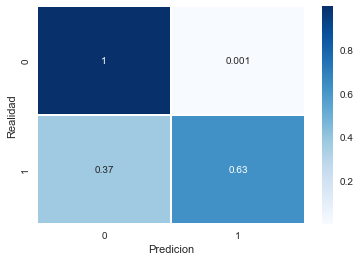

Predicion     0   1   All
Realidad                 
0          1979   2  1981
1            44  74   118
All        2023  76  2099


In [23]:
MetricasMatrixConfusion(y_train,Modelo,x_train)

Modelo AUC: 0.9966418261620993


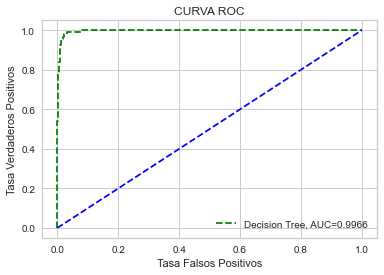

In [24]:
curva_roc(y_train,Modelo,x_train)

**Test**

Accuracy: 0.9544444444444444
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       849
           1       0.67      0.39      0.49        51

    accuracy                           0.95       900
   macro avg       0.82      0.69      0.73       900
weighted avg       0.95      0.95      0.95       900



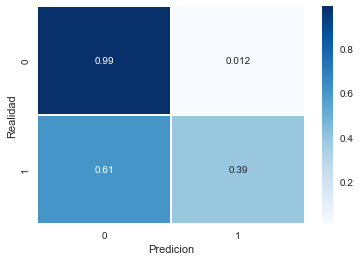

Predicion    0   1  All
Realidad               
0          839  10  849
1           31  20   51
All        870  30  900


In [25]:
MetricasMatrixConfusion(y_test,Modelo,x_test)

Modelo AUC: 0.9189357721887342


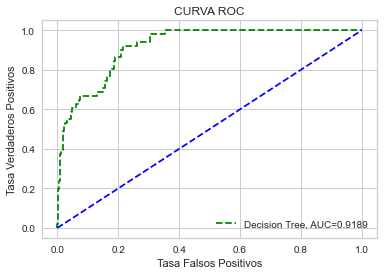

In [26]:
curva_roc(y_test,Modelo,x_test)

In [28]:
save_model(Modelo,"lightgbm")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Productos_Vehiculos_4',
                                              'Productos_Otros_2',
                                              'Mes Alta_Mayo',
                                              'Productos_Vida_3',
                                              'Mes Alta_Febrero',
                                              'Mes Alta_Agosto',
                                              'Productos_Otros_3',
                                              'Mes Alta_Julio',
                                              'Productos_Otros_5',
                                              'Mes Alta_Septiembre',
                                              'P...
                                 importance_type='split',
                                 learning_ra

In [32]:
x_test.shape

(900, 27)